# CCE Moorings Gridded vs. Nearest Neighbor depth Binning - Temporal Scales Analysis  

**Purpose**: Code for comparing the CCE mooring scale analysis between the gridded and nearest neighbor depth binning. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_obs           = 'CTD'  # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, doxy, chla, density
option_depth         = 0.5    # Specifies the depth level in meter at which the decorrelation data was computed

# Set time and space parameters
T               = 1*(60)*(60)                         # Spcifies the time interval for model run. Units: seconds
estimator       = 'biased'                            # Specifies the approach for estimating the autocorrelation function  
event_time_bnds_CCE1 = [datetime(2016, 1, 1, 0, 0, 0), datetime(2017, 12, 31, 23, 59, 59)]  # Specifies the event period
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze
M = 20

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load CCE intermediate data and mitgcm time scale analysis data

In [4]:
#--- MITgcm Data ---# 
ROOT_mitgcm = "/data/mitgcm/SWOT_MARA_RUN4_LY"
if option_var == 'temp':
    filename_decor   = PATH + ROOT_mitgcm + "/mitgcm_temporal_decorr_scale_temp_depth_" + str(option_depth) + "m.npz"
    filename_spectra = PATH + ROOT_mitgcm + "/mitgcm_temporal_psd_temp_depth_" + str(option_depth) + "m_numWindows_" + str(M) + ".npz"
elif option_var == 'sal':
    filename_decor   = PATH + ROOT_mitgcm + "/mitgcm_temporal_decorr_scale_sal_depth_" + str(option_depth) + "m.npz"
    filename_spectra = PATH + ROOT_mitgcm + "/mitgcm_temporal_psd_sal_depth_" + str(option_depth) + "m_numWindows_" + str(M) + ".npz"
elif option_var == 'density':
    filename_decor   = PATH + ROOT_mitgcm + "/mitgcm_temporal_decorr_scale_rho_depth_" + str(option_depth) + "m.npz"
    filename_spectra = PATH + ROOT_mitgcm + "/mitgcm_temporal_psd_rho_depth_" + str(option_depth) + "m_numWindows_" + str(M) + ".npz"

# Load data 
ds_decor   = np.load(filename_decor, allow_pickle=True)
ds_spectra = np.load(filename_spectra, allow_pickle=True)

# Extract data variables
lon_m             = ds_decor["lon"]
lat_m             = ds_decor["lat"]
time_scale_m      = ds_decor["time_scale"]   # Units: Seconds
autocorr_m        = ds_decor["autocorr"] 
Lt_m              = ds_decor["L_tm"]          # Units: Months

f_m               = ds_spectra["f"]          # Units: Hz
S_m               = ds_spectra["S"]
CI_m              = ds_spectra["CI"]

#--- CCE Scale Analysis Data ---# 
filename_CCE1_grid = PATH + "/data/CCE/CCE1/" + option_obs + "/CCE1_" + option_obs + "_" + str(event_time_bnds_CCE1[0].year) + str(event_time_bnds_CCE1[0].month) + str(event_time_bnds_CCE1[0].day) +  "-" + str(event_time_bnds_CCE1[1].year) + str(event_time_bnds_CCE1[1].month) + str(event_time_bnds_CCE1[1].day) + "_scale_data_gridded.npz"
filename_CCE1      = PATH + "/data/CCE/CCE1/" + option_obs + "/CCE1_" + option_obs + "_" + str(event_time_bnds_CCE1[0].year) + str(event_time_bnds_CCE1[0].month) + str(event_time_bnds_CCE1[0].day) +  "-" + str(event_time_bnds_CCE1[1].year) + str(event_time_bnds_CCE1[1].month) + str(event_time_bnds_CCE1[1].day) + "_scale_data.npz"

# Load data 
ds_decor_CCE1_grid   = np.load(filename_CCE1_grid, allow_pickle=True)
ds_decor_CCE1   = np.load(filename_CCE1, allow_pickle=True)

# Extract data variables

#--- CCE1 Grid ---# 
lon1_nc_grid          = ds_decor_CCE1_grid["lon"]
lat1_grid             = ds_decor_CCE1_grid["lat"]
depth1_grid           = ds_decor_CCE1_grid["depth"]

if option_var == 'temp':
    autocorr1_grid   = ds_decor_CCE1_grid["autocorr_temp"] 
    time_scale1_grid = ds_decor_CCE1_grid["time_scale_temp"] # Units: Seconds
    Lt1_grid         = ds_decor_CCE1_grid["Lt_temp"]         # Units: days
    S1_grid          = ds_decor_CCE1_grid["S_temp"] 
    CI1_grid         = ds_decor_CCE1_grid["CI_temp"]
    f1_grid          = ds_decor_CCE1_grid["f_temp"]          # Units: Hz
elif option_var == 'sal':
    autocorr1_grid   = ds_decor_CCE1_grid["autocorr_sal"] 
    time_scale1_grid = ds_decor_CCE1_grid["time_scale_sal"] 
    Lt1_grid         = ds_decor_CCE1_grid["Lt_sal"]
    S1_grid          = ds_decor_CCE1_grid["S_sal"] 
    CI1_grid         = ds_decor_CCE1_grid["CI_sal"]
    f1_grid          = ds_decor_CCE1_grid["f_sal"]
elif option_var == 'density':
    autocorr1_grid   = ds_decor_CCE1_grid["autocorr_rho"] 
    time_scale1_grid = ds_decor_CCE1_grid["time_scale_rho"] 
    Lt1_grid         = ds_decor_CCE1_grid["Lt_rho"]
    S1_grid          = ds_decor_CCE1_grid["S_rho"] 
    CI1_grid         = ds_decor_CCE1_grid["CI_rho"]
    f1_grid          = ds_decor_CCE1_grid["f_rho"]

#--- CCE1 ---# 
lon1_nc          = ds_decor_CCE1["lon"]
lat1             = ds_decor_CCE1["lat"]
depth1           = ds_decor_CCE1["depth"]

if option_var == 'temp':
    autocorr1   = ds_decor_CCE1["autocorr_temp"] 
    time_scale1 = ds_decor_CCE1["time_scale_temp"] # Units: Seconds
    Lt1         = ds_decor_CCE1["Lt_temp"]         # Units: days
    S1          = ds_decor_CCE1["S_temp"] 
    CI1         = ds_decor_CCE1["CI_temp"]
    f1          = ds_decor_CCE1["f_temp"]          # Units: Hz
elif option_var == 'sal':
    autocorr1   = ds_decor_CCE1["autocorr_sal"] 
    time_scale1 = ds_decor_CCE1["time_scale_sal"] 
    Lt1         = ds_decor_CCE1["Lt_sal"]
    S1          = ds_decor_CCE1["S_sal"] 
    CI1         = ds_decor_CCE1["CI_sal"]
    f1          = ds_decor_CCE1["f_sal"]
elif option_var == 'density':
    autocorr1   = ds_decor_CCE1["autocorr_rho"] 
    time_scale1 = ds_decor_CCE1["time_scale_rho"] 
    Lt1         = ds_decor_CCE1["Lt_rho"]
    S1          = ds_decor_CCE1["S_rho"] 
    CI1         = ds_decor_CCE1["CI_rho"]
    f1          = ds_decor_CCE1["f_rho"]

# Convert the longitude value of the cce data
lon1 = lon1_nc % 360

# Convert decorrelation scale to days
Lt_mdays = Lt_m*(30)

Grab data from near the moorings

In [5]:
# Find the spatial indices of the longitude and latitude point
idx_lon_cce1 = np.argmin(np.abs(lon_m - lon1))
idx_lat_cce1 = np.argmin(np.abs(lat_m - lat1))

# Extract data 
time_scale_mc1      = np.squeeze(time_scale_m[:,idx_lat_cce1,idx_lon_cce1])
autocorr_mc1        = np.squeeze(autocorr_m[:,idx_lat_cce1,idx_lon_cce1])
Lt_mc1              = np.squeeze(Lt_mdays[idx_lat_cce1,idx_lon_cce1])
S_mc1               = np.squeeze(S_m[:,idx_lat_cce1,idx_lon_cce1])
CI_mc1              = np.squeeze(CI_m[:,:,idx_lat_cce1,idx_lon_cce1])

Compute the inertial frequency and the frequency associated with the decorrelation scale

In [6]:
# Multiply the decorrelation scale by pi so that it is comparable to the period of a signal
T1 = Lt1[0]
T1m = Lt_mc1

# Compute its associated frequency in units of cpd 
f_decor1 = 1/T1
f_decor1m = 1/T1m

# Compute the interial period in units of cpd
omega = (7.2921*10**(-5))/(2*np.pi)                                # Units: Hz 
f_inertial = 2*omega*np.sin(np.deg2rad(np.mean(lat_m)))*(86400)    # Units: cpd

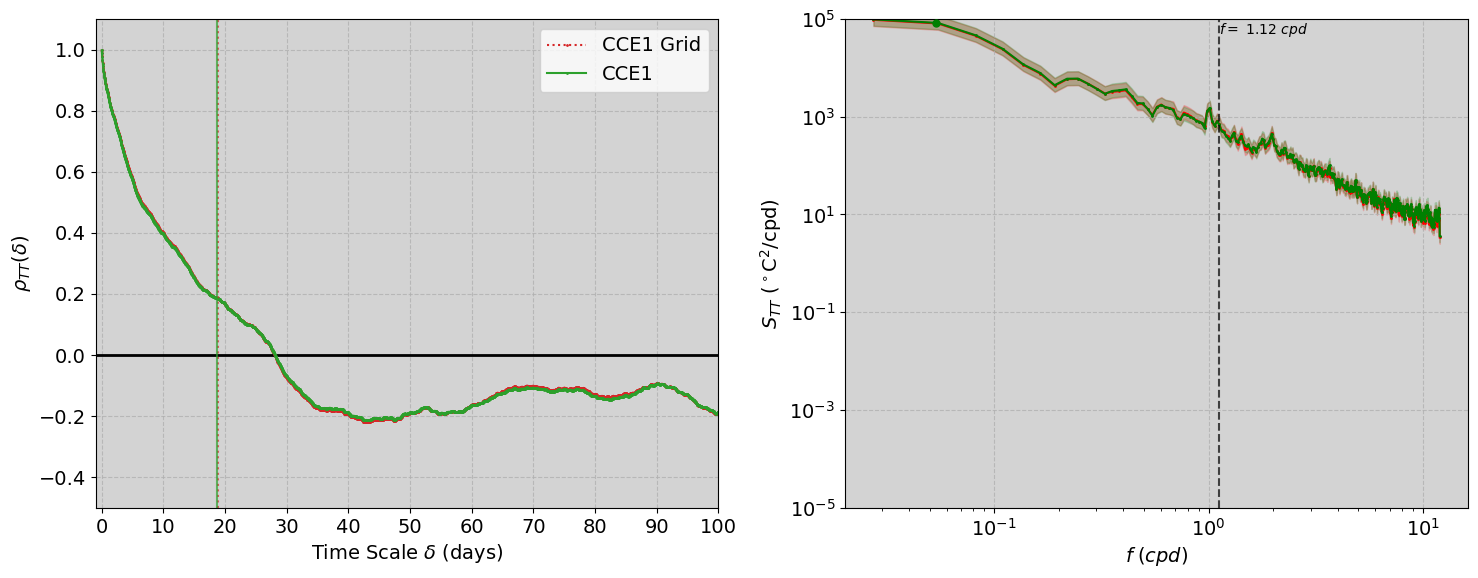

In [18]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set the depth index
idepth = 0

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
    ylabel_spec = r'$S_{TT}$ ($^\circ$C$^2$/cpd)'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
    ylabel_spec = r'$S_{SS}$ ($(g/kg)^2$/cpd)'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Convert time scale to days
time_scale_mc_days1 = time_scale_mc1*(1/60)*(1/60)*(1/24)
time_scale_days1 = time_scale1*(1/60)*(1/60)*(1/24)
time_scale_grid_days1 = time_scale1_grid*(1/60)*(1/60)*(1/24)

# Convert to cycles per day
f1_cpd = f1*(60)*(60)*(24)
f1_cpd_grid = f1_grid*(60)*(60)*(24)
f_mcpd = f_m*(60)*(60)*(24)

# Create figure 
fig, ax = plt.subplots(1,2,figsize=(15, 6))

# Determine upper y-limit from your spectra 
ymin, ymax = 1e-5, 1e5 #1e-2, 1e7 #1e-5, 1e5
ax[1].set_ylim(bottom=ymin, top=ymax)  # Adjust lower limit if needed

#--- Subplot #1 ---# 

# Plot the zero crossing line
ax[0].axhline(0, color='k', linestyle='-', linewidth=2)

# Plot autocorrelations

#--- CCE1 ---# 
ax[0].plot(time_scale_grid_days1[:,idepth], autocorr1_grid[:,idepth], '.:', label=f"CCE1 Grid", color='tab:red', linewidth=1.5, markersize=2)
ax[0].plot(time_scale_days1[:,idepth], autocorr1[:,idepth], '.-', label=f"CCE1", color='tab:green', linewidth=1.5, markersize=2)
#ax[0].plot(time_scale_mc_days1, autocorr_mc1, '--', label=f"Model CCE1", color='tab:blue', linewidth=1.5, markersize=2)

# Plot decorrelation scales
ax[0].axvline(Lt1_grid[idepth], color='tab:red', linestyle=':', alpha=0.7)
ax[0].axvline(Lt1[idepth], color='tab:green', linestyle='-', alpha=0.7)
#ax[0].axvline(Lt_mc1, color='tab:blue', linestyle='--', alpha=0.7)

# Set legend
ax[0].legend(loc='upper right')

# Set figure attributes
ax[0].set_xlabel(r"Time Scale $\delta$ (days)")
ax[0].set_ylabel(ylabel)
ax[0].set_xlim(-1,100)
ax[0].set_ylim(-0.5,1.1)
ax[0].set_xticks(np.arange(0,110,10))
ax[0].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[0].set_facecolor('lightgray')

#--- Subplot #2 ---# 

# Plot each depth the spectrum, confidence intervals and the decorrelation scale

#--- CCE 1 ---# 
ax[1].loglog(f1_cpd_grid[1:], S1_grid[1:,idepth], '.-', color='red', linewidth=1.5, markersize=2)
ax[1].fill_between(f1_cpd_grid[1:],CI1_grid[1:,0,idepth],CI1_grid[1:,1,idepth],color='red',alpha=0.2)

ax[1].loglog(f1_cpd[1:], S1[1:,idepth], '.-', color='green', linewidth=1.5, markersize=2)
ax[1].fill_between(f1_cpd[1:],CI1[1:,0,idepth],CI1[1:,1,idepth],color='green',alpha=0.2)

# ax[1].loglog(f_mcpd[1:], S_mc1[1:], '.-', color='tab:blue', linewidth=1.5, markersize=2, linestyle='--')
# ax[1].fill_between(f_mcpd[1:],CI_mc1[1:,0],CI_mc1[1:,1],color='tab:blue',alpha=0.2)

# Interpolate power spectrum at f_i
S_decor1 = np.interp(f_decor1, f1_cpd, S1[:, idepth])
#S_decor1m = np.interp(f_decor1m, f_mcpd, S_mc1)

# Plot vertical line *only down to the spectrum*
ax[1].plot([f_decor1, f_decor1], [S_decor1, ymax], linestyle='-', color='green', linewidth=1.5)
#ax[1].plot([f_decor1m, f_decor1m], [S_decor1m, ymax], linestyle='--', color='tab:green', linewidth=1.5)

# Plot a marker at the intersection point
ax[1].plot(f_decor1, S_decor1, marker='o', color='green', markersize=5, zorder=5)
#ax[1].plot(f_decor1m, S_decor1m, marker='o', color='tab:green', markersize=5, zorder=5)

# Plot the inertial frequency
ax[1].axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
ax[1].text(f_inertial, plt.ylim()[1]*0.6, r'$f = $ ' + str(np.round(f_inertial,2)) + r' $cpd$', rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

# Set figure attributes
ax[1].set_xlabel(r"$f \;(cpd)$")
ax[1].set_ylabel(ylabel_spec)
ax[1].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[1].set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()